In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [3]:
path = '../abalone/abalone.data'
df = pd.read_csv(path, names=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


rings
1    1891
2    1186
0     839
3     261
Name: count, dtype: int64


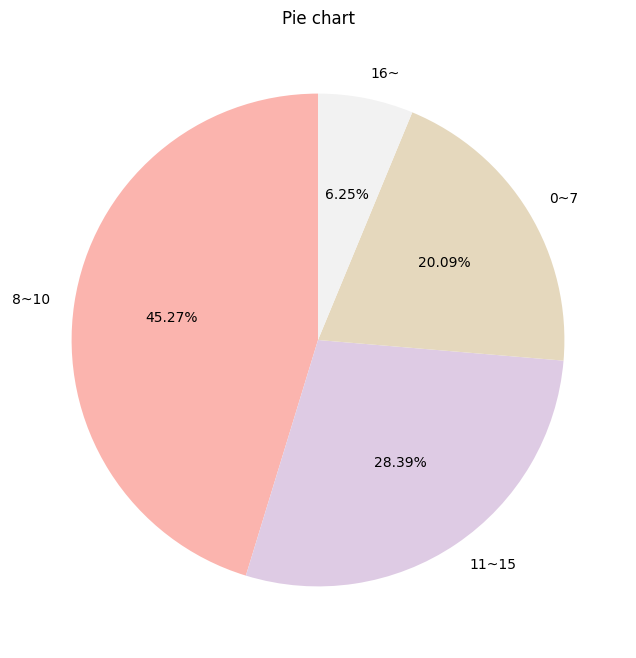

In [4]:
# Use the recommend multiclass classifier
def multi_class(x):
    if x <= 7:
        return 0
    elif x <= 10:
        return 1
    elif x <= 15:
        return 2
    else:
        return 3
class_dict = {0: '0~7', 1: '8~10', 2: '11~15', 3: '16~'}
# Use different number to map the value of ring-age
y = df.iloc[:, -1].map(multi_class)
X = df.iloc[:, :-1]
# 对性别进行映射
X['sex'] = X['sex'].map({'M': 0, 'F': 1, 'I': 3})
# 这里用的是老师的方法分类,并不均匀
print(y.value_counts())
cmap = cm.get_cmap('Pastel1')
abalone_colors = [cmap(i) for i in np.linspace(0, 1, len(y.value_counts()))]
plt.figure(figsize=(8, 8))
plt.pie(y.value_counts(), autopct='%.2f%%',
        startangle=90, labels=[class_dict[s] for s in y.value_counts().index], colors=abalone_colors)
plt.title('Pie chart')
plt.show()

In [5]:
# 还可以使用分桶的操作，来保证分布均匀的问题
#bins_1 可以让每个去区间的分布数量尽量平均
bins_1 = pd.qcut(df.iloc[:, -1], q=4)
print(bins_1.value_counts())
# bins_2 让数值区间相同
bins_2 = pd.cut(df.iloc[:, -1], bins=4)
print(bins_2.value_counts())

rings
(0.999, 8.0]    1407
(9.0, 11.0]     1121
(11.0, 29.0]     960
(8.0, 9.0]       689
Name: count, dtype: int64
rings
(8.0, 15.0]     2509
(0.972, 8.0]    1407
(15.0, 22.0]     245
(22.0, 29.0]      16
Name: count, dtype: int64


In [6]:
# 由于数据是处理过的，不需要再去做额外的特征工程
# 由于是多分类，我们可以使用One-to-one或者One-to-rest的方式
# 同时引入K折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def simple_nn_train(model, X=X, y=y, only=None,iter=30):
    ovo = []
    ovr = []
    for stra in ['ovo', 'ovr']:
        if only and stra not in only: continue;
        f1_socre_list = []
        roc_auc_score_list = []
        acc_score_list = []
        for i in range(1, iter + 1):
            f1_res = []
            roc_auc_res = []
            acc_res = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)
                f1 = f1_score(y_test, y_pred, average='micro')
                roc_auc = roc_auc_score(y_test, y_prob, multi_class=stra)
                acc = accuracy_score(y_test, y_pred)
                f1_res.append(f1)
                roc_auc_res.append(roc_auc)
                acc_res.append(acc)
            f1_res_mean = np.mean(f1_res)
            roc_auc_res_mean = np.mean(roc_auc_res)
            acc_res_mean = np.mean(acc_res)
            if i % (iter / 10) == 0:
                print(
                    f'Iteration {i}/ {iter}: Using Stragety {stra} f1_score={f1_res_mean:.3f}; roc_auc={roc_auc_res_mean:.3f}; accuracy={acc_res_mean:.3f}')
            f1_socre_list.append(f1_res_mean)
            roc_auc_score_list.append(roc_auc_res_mean)
            acc_score_list.append(acc_res_mean)
        print(
            f'Final Summary: Iterations {iter}, Stragety {stra}, f1_score={f1_socre_list[-1]:.3f}, roc_auc={roc_auc_score_list[-1]:.3f}, accuracy={acc_score_list[-1]:.3f}')
        if stra == 'ovo':
            ovo.append(f1_socre_list)
            ovo.append(roc_auc_score_list)
        else:
            ovr.append(f1_socre_list)
            ovr.append(roc_auc_score_list)
    return ovo, ovr

In [ ]:
iters = 200
print('Using solver=sgd')
default_ovo, default_ovr = simple_nn_train(MLPClassifier(warm_start=True, solver='sgd',early_stopping=True), iter=iters)
print('Using solver=adam')
adam_ovo, adam_ovr = simple_nn_train(MLPClassifier(solver='adam', warm_start=True, early_stopping=True), iter=iters)

Using solver=adam
Iteration 20/ 200: Using Stragety ovo f1_score=0.634; roc_auc=0.846; accuracy=0.634
Iteration 40/ 200: Using Stragety ovo f1_score=0.638; roc_auc=0.853; accuracy=0.638
Iteration 60/ 200: Using Stragety ovo f1_score=0.646; roc_auc=0.856; accuracy=0.646
Iteration 80/ 200: Using Stragety ovo f1_score=0.647; roc_auc=0.857; accuracy=0.647
Iteration 100/ 200: Using Stragety ovo f1_score=0.655; roc_auc=0.861; accuracy=0.655
Iteration 120/ 200: Using Stragety ovo f1_score=0.655; roc_auc=0.863; accuracy=0.655
Iteration 140/ 200: Using Stragety ovo f1_score=0.656; roc_auc=0.864; accuracy=0.656
Iteration 160/ 200: Using Stragety ovo f1_score=0.654; roc_auc=0.866; accuracy=0.654
Iteration 180/ 200: Using Stragety ovo f1_score=0.656; roc_auc=0.864; accuracy=0.656
Iteration 200/ 200: Using Stragety ovo f1_score=0.653; roc_auc=0.865; accuracy=0.653
Final Summary: Iterations 200, Stragety ovo, f1_score=0.653, roc_auc=0.865, accuracy=0.653
Iteration 20/ 200: Using Stragety ovr f1_scor

In [7]:
# 绘制收敛速度的曲线
# 封装绘制图片的函数
def plot_scores(tag='SGD', iters=iters, data=None, score='f1_score'):
    if score == 'f1_score': d = 0
    else: d = 1
    plt.plot(range(1, iters + 1), data[d], label=tag)

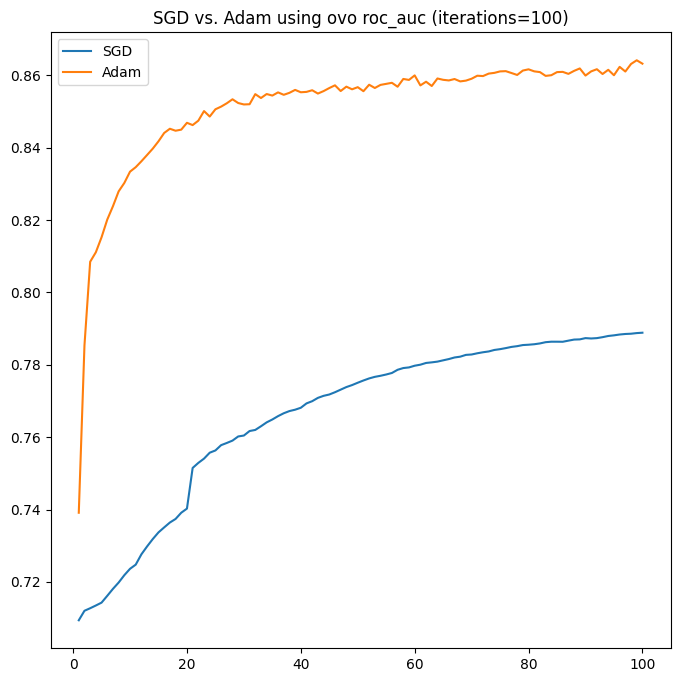

In [8]:
plt.figure(figsize=(8, 8))
plot_scores(tag='SGD', data=default_ovo, score='roc_auc')
plot_scores(tag='Adam', data=adam_ovo, score='roc_auc')
plt.title(f'SGD vs. Adam using ovo roc_auc (iterations={iters})')
plt.legend()
plt.show()

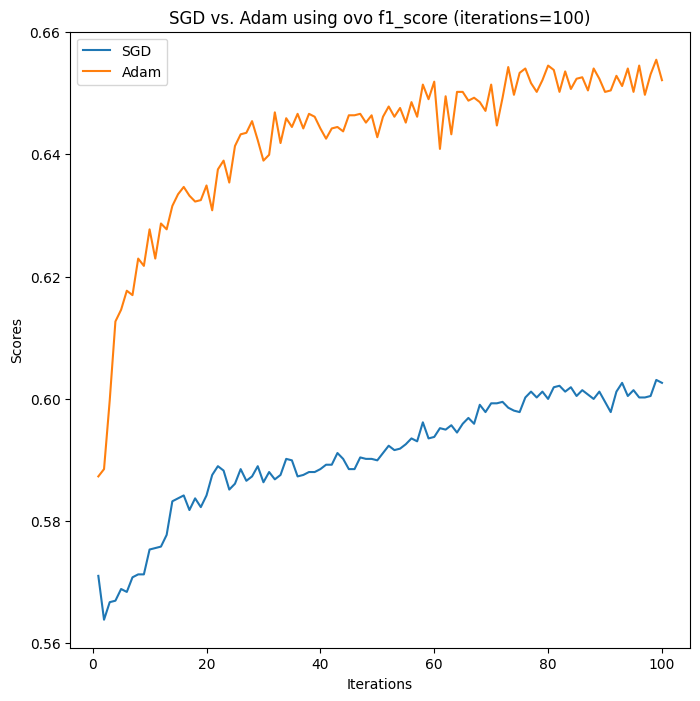

In [9]:
plt.figure(figsize=(8, 8))
plot_scores(tag='SGD', data=default_ovo, score='f1_score')
plot_scores(tag='Adam', data=adam_ovo, score='f1_score')
plt.title(f'SGD vs. Adam using ovo f1_score (iterations={iters})')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.legend()
plt.show()
# 由于ovr表现不稳定没法体现Adam的优势，所以不画图

In [67]:
# 由于后面需要使用到dropout的技巧，这里就需要调用pytorch里面的神经网络了
# 先构建一个使用Adam作为优化器并且添加了L2的神经网络
class SNN(nn.Module):
    def __init__(self, n_class=4):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, n_class)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [68]:
# 处理数据
def data2loader(X, y, batch_size=64, val_pct=0.3):
    X_tensor, y_tensor = torch.tensor(X.values), torch.tensor(y.values)


    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int((1 - val_pct) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader
train_loader, val_loader = data2loader(X, y)

In [133]:

epoches = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

def train_eval(model, device, train_loader, val_loader, epoches, lr=0.001, weight_decay=0, verbose=True):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    val_f1_score_list = []
    val_roc_auc_score_list = []
    train_f1_score_list = []
    train_roc_auc_score_list = []
    finally_f1 = 0
    finally_roc_auc = 0
    for epoch in range(epoches):
        model.train()
        train_pred = []
        train_labels = []
        train_prob = []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_pred.extend(predicted.cpu().detach().numpy())
            train_labels.extend(labels.cpu().detach().numpy())
            train_prob.extend(outputs.cpu().detach().numpy())
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0 and verbose:
            print('Epoch:', epoch, 'Loss:', loss.item())
        train_f1 = f1_score(train_labels, train_pred, average='micro')
        train_roc_auc = roc_auc_score(
            train_labels, train_prob, multi_class='ovr', average='weighted')
        train_f1_score_list.append(train_f1)
        train_roc_auc_score_list.append(train_roc_auc)
        model.eval()
        correct = 0
        total = 0
        val_pred = []
        val_labels = []
        val_prob = []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_pred.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_prob.extend(outputs.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if epoch % 10 == 0 and verbose:
            print('Epoch:', epoch, 'Accuracy', round(correct / total, 5))
        finally_f1 = f1_score(val_labels, val_pred, average='micro')
        finally_roc_auc = roc_auc_score(val_labels, val_prob, multi_class='ovr', average='macro')
        val_f1_score_list.append(finally_f1.copy())
        val_roc_auc_score_list.append(finally_roc_auc.copy())
    print(f'Final Summary: f1_score {finally_f1:.5f}; roc_auc_score {finally_roc_auc:.5f}')
    return [train_f1_score_list, train_roc_auc_score_list], [val_f1_score_list, val_roc_auc_score_list]

In [131]:
# 对比不同的dropout的收敛速度,图片
def epoch_plot(data, epoches, score, tag):
    if len(data) != len(tag):
        return 'Error need the same number of data and tag'
    plt.figure(figsize=(8, 8))
    for i in range(len(data)):
        plt.plot(range(1, epoches + 1), data[i], label=tag[i])
    name = ' vs '.join(tag)+ '_' + score + '_comparison'
    plt.title(f'Epoch {epoches} {name}')
    plt.legend()
    plt.savefig(f'{name}.png')

In [116]:
default_train, default_val = train_eval(SNN(), device, train_loader, val_loader=val_loader, epoches=epoches)

Epoch: 0 Loss: 1.3388490676879883
Epoch: 0 Accuracy 0.44338
Epoch: 10 Loss: 1.1598562002182007
Epoch: 10 Accuracy 0.58533
Epoch: 20 Loss: 1.2151720523834229
Epoch: 20 Accuracy 0.59569
Epoch: 30 Loss: 1.1741524934768677
Epoch: 30 Accuracy 0.59809
Epoch: 40 Loss: 1.0593295097351074
Epoch: 40 Accuracy 0.61722
Epoch: 50 Loss: 1.0101920366287231
Epoch: 50 Accuracy 0.61882
Epoch: 60 Loss: 1.064806342124939
Epoch: 60 Accuracy 0.62839
Epoch: 70 Loss: 1.1144529581069946
Epoch: 70 Accuracy 0.62759
Epoch: 80 Loss: 1.0031163692474365
Epoch: 80 Accuracy 0.63955
Epoch: 90 Loss: 1.1984343528747559
Epoch: 90 Accuracy 0.64673
Epoch: 100 Loss: 1.177433729171753
Epoch: 100 Accuracy 0.64035
Epoch: 110 Loss: 1.001573920249939
Epoch: 110 Accuracy 0.64753
Epoch: 120 Loss: 1.041637659072876
Epoch: 120 Accuracy 0.64035
Epoch: 130 Loss: 1.1199564933776855
Epoch: 130 Accuracy 0.63955
Epoch: 140 Loss: 0.9819915890693665
Epoch: 140 Accuracy 0.65311
Epoch: 150 Loss: 0.9670180678367615
Epoch: 150 Accuracy 0.63477
Ep

In [117]:
# 引入Dropout
class SNNDropout(nn.Module):
    def __init__(self, dropout=0.5, n_class=4):
        super(SNNDropout, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.drop = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(64, n_class)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [126]:
dropout_train, dropout_val =train_eval(SNNDropout(dropout=0.5), device, train_loader, val_loader=val_loader, epoches=epoches)

Epoch: 0 Loss: 1.323838710784912
Epoch: 0 Accuracy 0.44338
Epoch: 10 Loss: 1.1454017162322998
Epoch: 10 Accuracy 0.57656
Epoch: 20 Loss: 1.1241785287857056
Epoch: 20 Accuracy 0.58772
Epoch: 30 Loss: 1.1802020072937012
Epoch: 30 Accuracy 0.58373
Epoch: 40 Loss: 1.0818307399749756
Epoch: 40 Accuracy 0.60048
Epoch: 50 Loss: 1.041523814201355
Epoch: 50 Accuracy 0.60845
Epoch: 60 Loss: 1.0614848136901855
Epoch: 60 Accuracy 0.61085
Epoch: 70 Loss: 1.1192563772201538
Epoch: 70 Accuracy 0.6252
Epoch: 80 Loss: 1.1298025846481323
Epoch: 80 Accuracy 0.62759
Epoch: 90 Loss: 1.1108394861221313
Epoch: 90 Accuracy 0.62839
Epoch: 100 Loss: 1.0874736309051514
Epoch: 100 Accuracy 0.63876
Epoch: 110 Loss: 1.090303897857666
Epoch: 110 Accuracy 0.63876
Epoch: 120 Loss: 1.1768391132354736
Epoch: 120 Accuracy 0.64514
Epoch: 130 Loss: 1.0657652616500854
Epoch: 130 Accuracy 0.63796
Epoch: 140 Loss: 1.1390130519866943
Epoch: 140 Accuracy 0.63158
Epoch: 150 Loss: 1.0692459344863892
Epoch: 150 Accuracy 0.63557
Ep

In [136]:
# 加入l2正则化
l2_train, l2_val = train_eval(SNN(), device=device, train_loader=train_loader, val_loader=val_loader, epoches=epoches, weight_decay=0.001)

Epoch: 0 Loss: 1.3405721187591553
Epoch: 0 Accuracy 0.44338
Epoch: 10 Loss: 1.1891497373580933
Epoch: 10 Accuracy 0.5941
Epoch: 20 Loss: 1.1848478317260742
Epoch: 20 Accuracy 0.59011
Epoch: 30 Loss: 1.141149640083313
Epoch: 30 Accuracy 0.59729
Epoch: 40 Loss: 1.1794822216033936
Epoch: 40 Accuracy 0.59091
Epoch: 50 Loss: 1.0760807991027832
Epoch: 50 Accuracy 0.58852
Epoch: 60 Loss: 1.1455129384994507
Epoch: 60 Accuracy 0.61404
Epoch: 70 Loss: 1.1521825790405273
Epoch: 70 Accuracy 0.62041
Epoch: 80 Loss: 1.0523067712783813
Epoch: 80 Accuracy 0.61802
Epoch: 90 Loss: 1.1824471950531006
Epoch: 90 Accuracy 0.63078
Epoch: 100 Loss: 1.0790419578552246
Epoch: 100 Accuracy 0.626
Epoch: 110 Loss: 1.1299161911010742
Epoch: 110 Accuracy 0.63557
Epoch: 120 Loss: 1.123073697090149
Epoch: 120 Accuracy 0.63557
Epoch: 130 Loss: 1.178792119026184
Epoch: 130 Accuracy 0.62919
Epoch: 140 Loss: 1.1957988739013672
Epoch: 140 Accuracy 0.63477
Epoch: 150 Loss: 0.9904049038887024
Epoch: 150 Accuracy 0.63716
Epoc

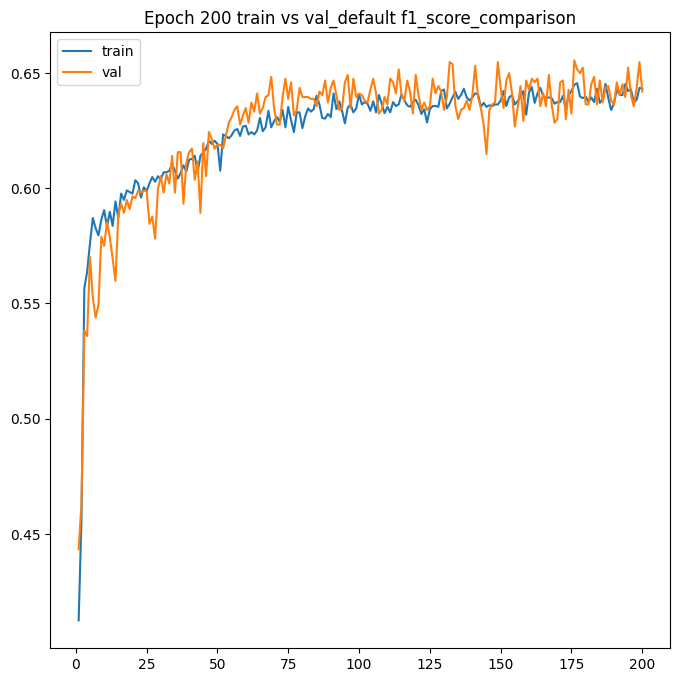

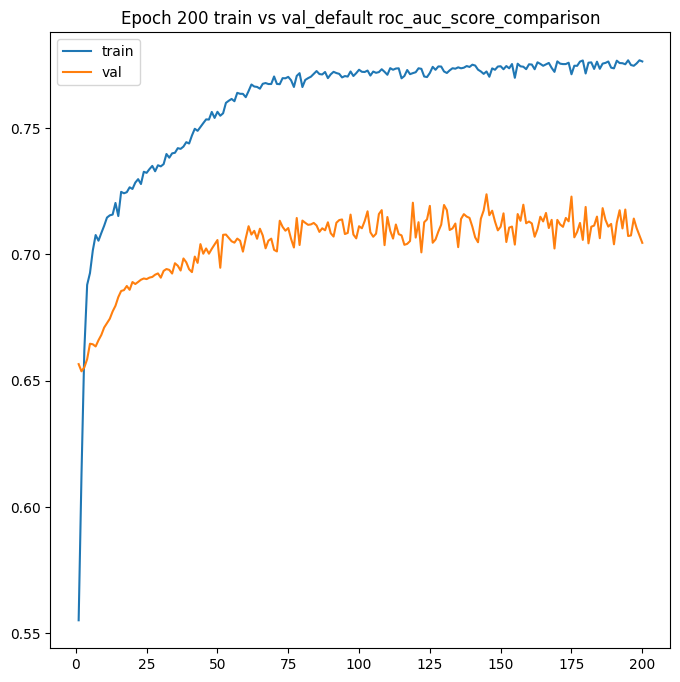

In [128]:
epoch_plot([default_train[0], default_val[0]], epoches, 'default f1_score', ['train', 'val'])
epoch_plot([default_train[1], default_val[1]], epoches, 'default roc_auc_score', ['train', 'val'])

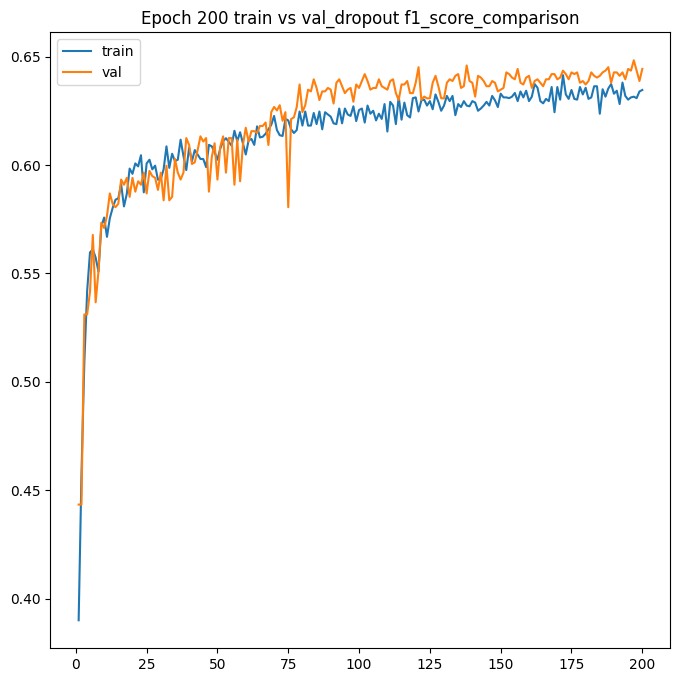

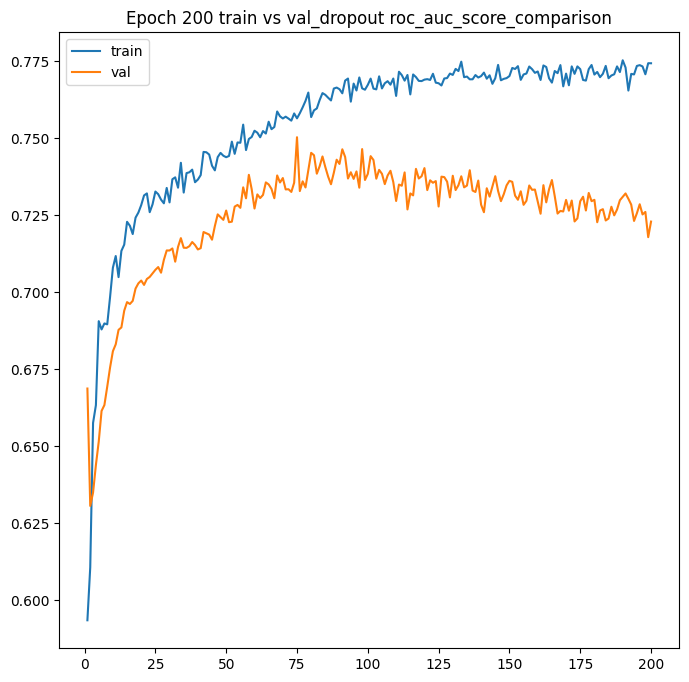

In [129]:
epoch_plot([dropout_train[0], dropout_val[0]], epoches,
           'dropout f1_score', ['train', 'val'])
epoch_plot([dropout_train[1], dropout_val[1]], epoches,
           'dropout roc_auc_score', ['train', 'val'])

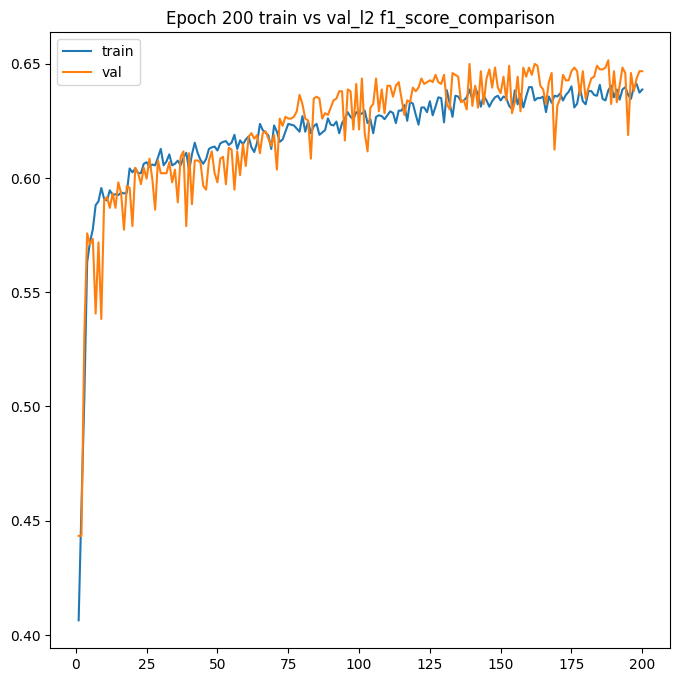

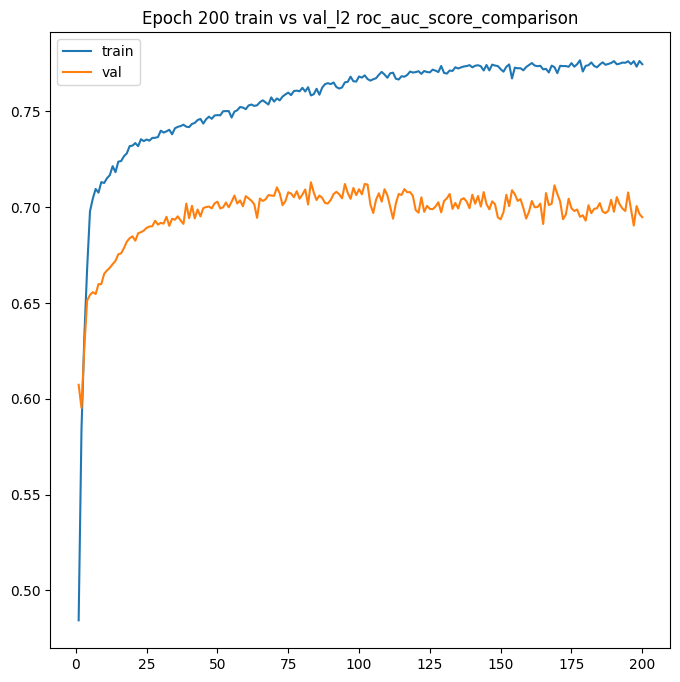

In [122]:
epoch_plot([l2_train[0], l2_val[0]], epoches, 'l2 f1_score', ['train', 'val'])
epoch_plot([l2_train[1], l2_val[1]], epoches, 'l2 roc_auc_score', ['train', 'val'])

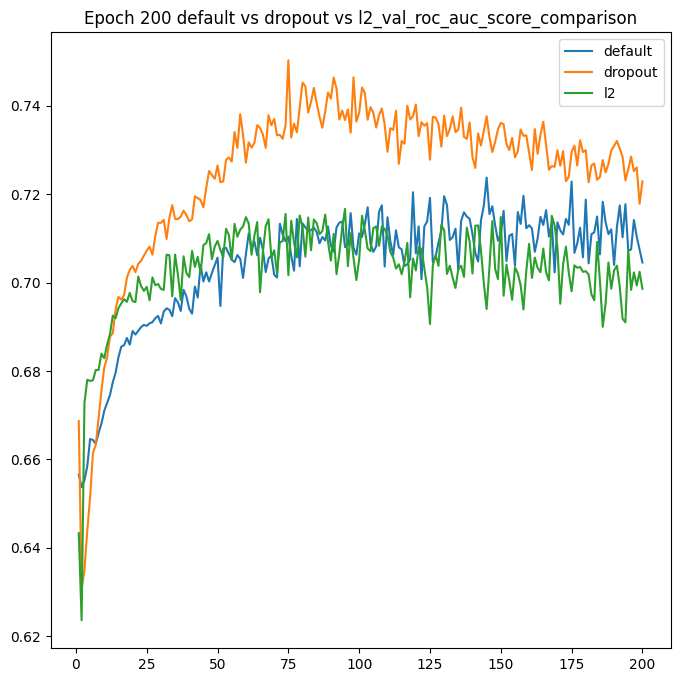

In [134]:
epoch_plot([default_val[1], dropout_val[1], l2_val[1]], epoches, 'val_roc_auc_score', ['default', 'dropout', 'l2'])

In [20]:
# 尝试不同的combination来测试
dropouts = [0.2, 0.3, 0.4, 0.5]
weight_decays = [1e-2, 1e-3, 5e-3, 5e-4]


In [ ]:
for d_rate in dropouts:
    print(f'Dropout: {d_rate}')
    train_eval(SNNDropout(d_rate), device, train_loader, val_loader=val_loader, epoches=epoches, verbose=False)
for w_decay in weight_decays:
    print(f'Weight decay: {w_decay}')
    train_eval(SNN(), device, train_loader, val_loader=val_loader, epoches=epoches, weight_decay=w_decay, verbose=False)

Dropout: 0.2
Final Summary: f1_score 0.63397; roc_auc_score 0.73965
Dropout: 0.3
Final Summary: f1_score 0.63955; roc_auc_score 0.73829
Dropout: 0.4
Final Summary: f1_score 0.64354; roc_auc_score 0.72850
Dropout: 0.5
Final Summary: f1_score 0.65391; roc_auc_score 0.72193
Weight decay: 0.01
Final Summary: f1_score 0.60526; roc_auc_score 0.68978
Weight decay: 0.001
Final Summary: f1_score 0.63796; roc_auc_score 0.71403
Weight decay: 0.005
Final Summary: f1_score 0.60606; roc_auc_score 0.69426
Weight decay: 0.0005
Final Summary: f1_score 0.64673; roc_auc_score 0.71639


In [ ]:
data = pd.read_csv('../cmc/cmc.data')
X_B = data.iloc[:, :-1]
y_B = data.iloc[:, -1:]

{'uci_id': 30, 'name': 'Contraceptive Method Choice', 'repository_url': 'https://archive.ics.uci.edu/dataset/30/contraceptive+method+choice', 'data_url': 'https://archive.ics.uci.edu/static/public/30/data.csv', 'abstract': 'Dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1473, 'num_features': 9, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Education Level', 'Other', 'Occupation'], 'target_col': ['contraceptive_method'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C59W2D', 'creators': ['Tjen-Sien Lim'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either

In [17]:
# 先看看缺失集的问题
print('The distribution nan value in different features')
X_B.isna().sum()

The distribution nan value in different features


wife_age                    0
wife_edu                    0
husband_edu                 0
num_children                0
wife_religion               0
wife_working                0
husband_occupation          0
standard_of_living_index    0
media_exposure              0
dtype: int64

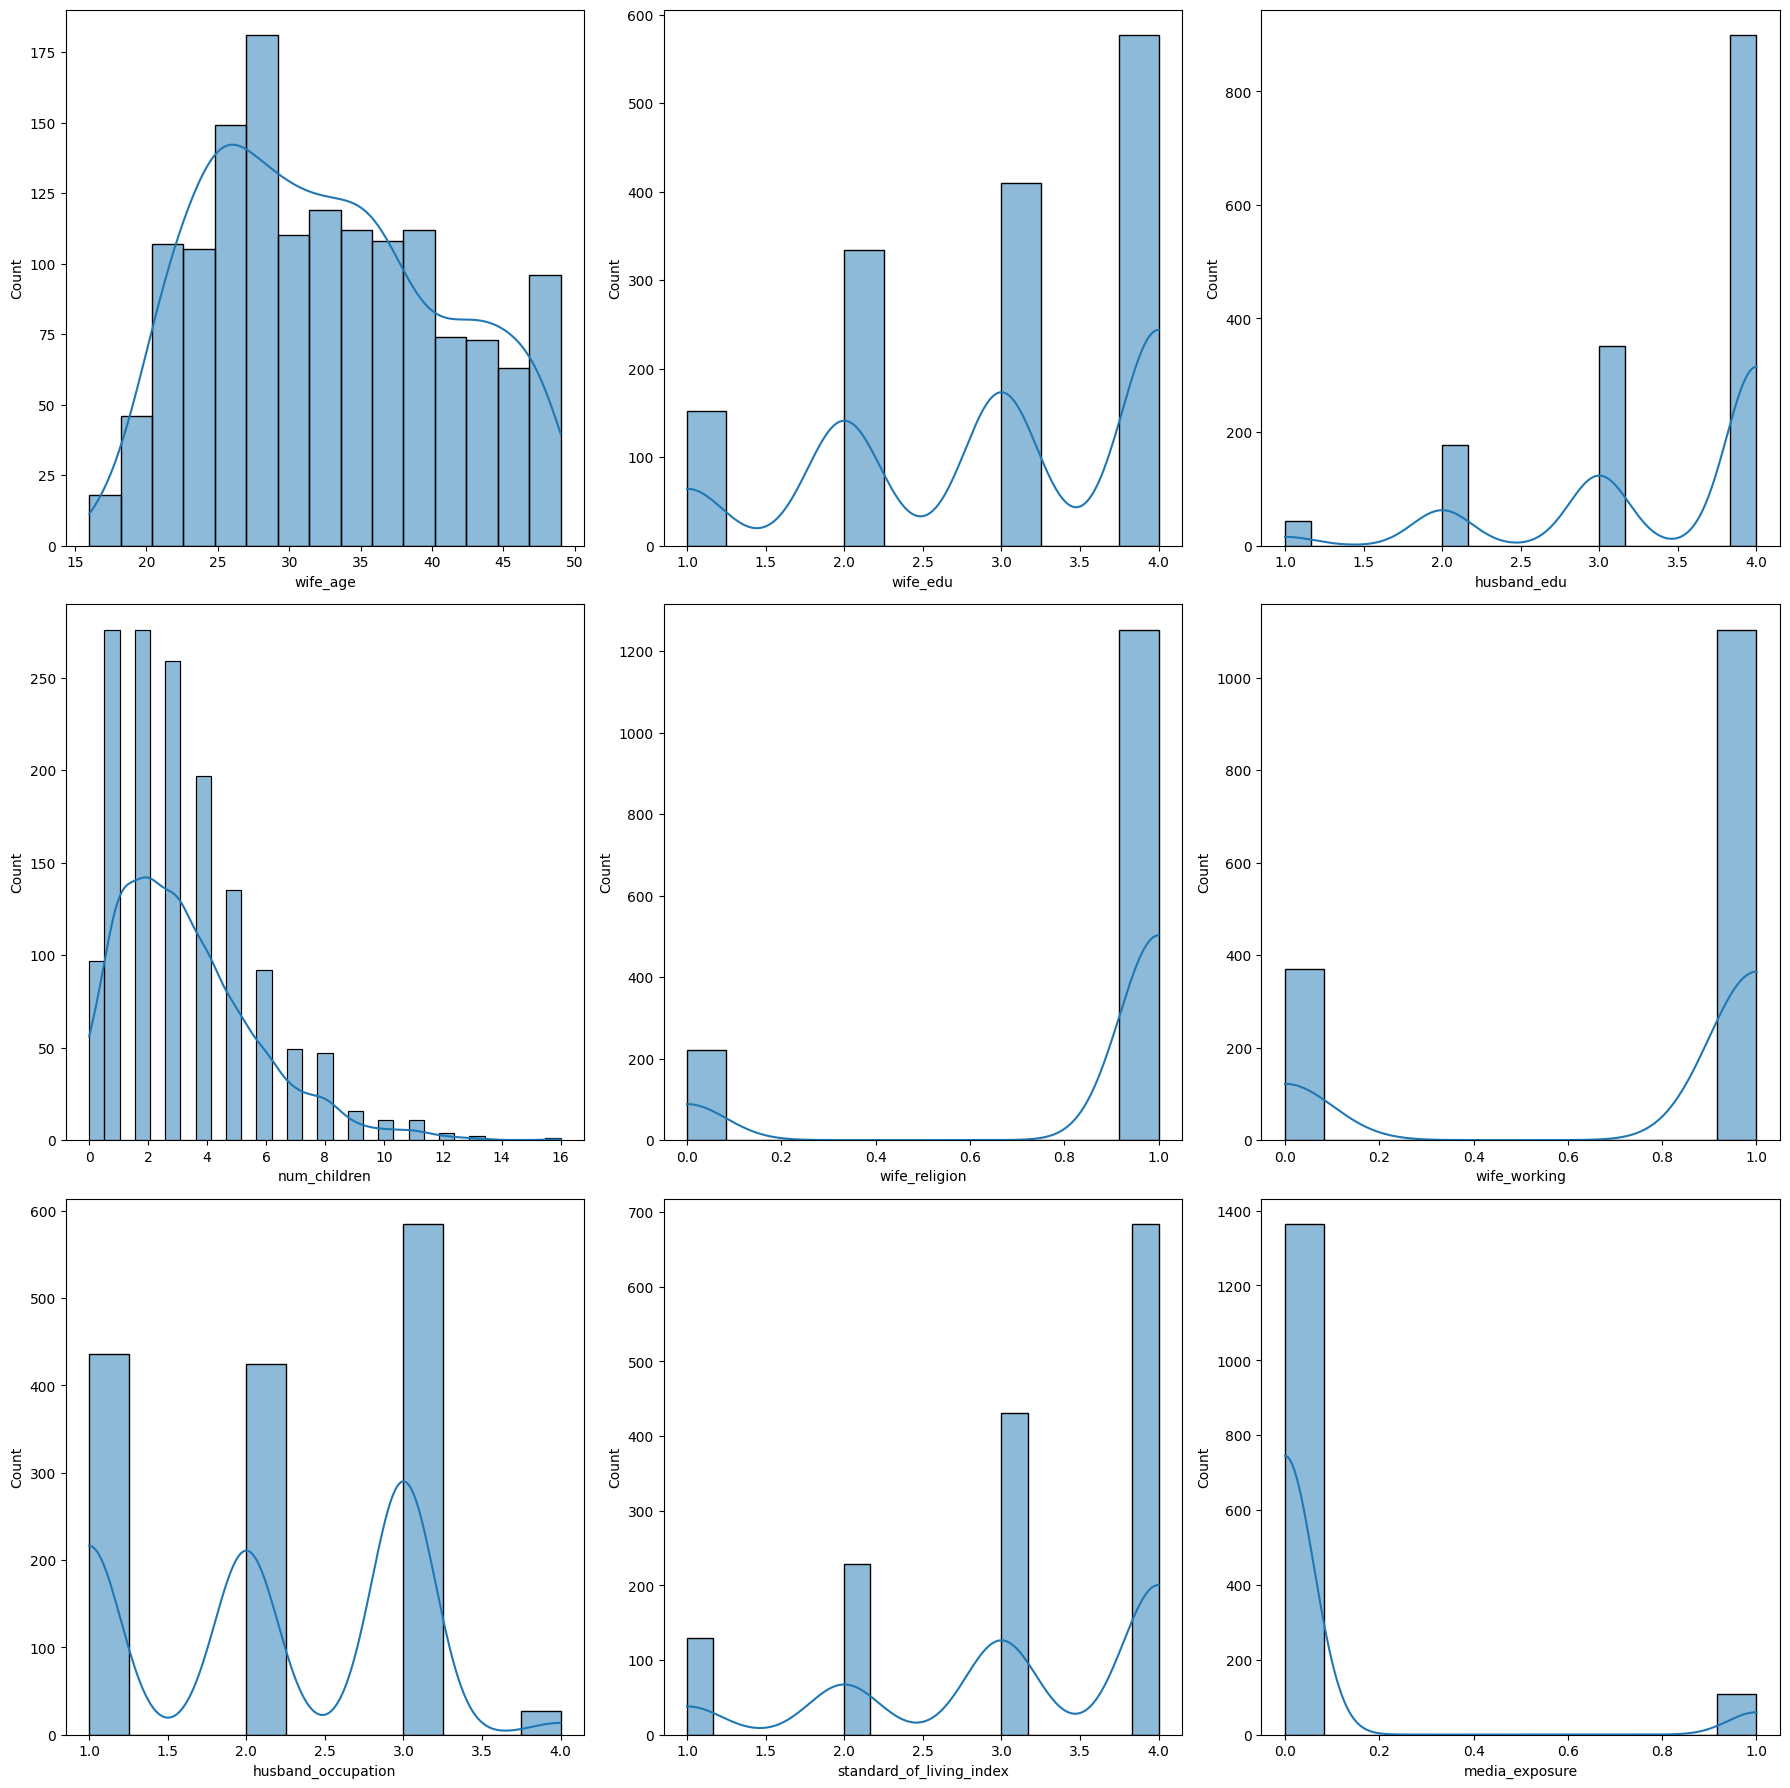

In [18]:
# 使用可视化分析每个变量的分布函数
plt.figure(figsize=(18, 18))
for i, col in enumerate(X_B.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(X_B[col], kde=True)
plt.tight_layout()

In [ ]:
[i for i in y_B.value_counts().index]

[1, 3, 2]

Text(0.5, 1.0, 'Pie chart')

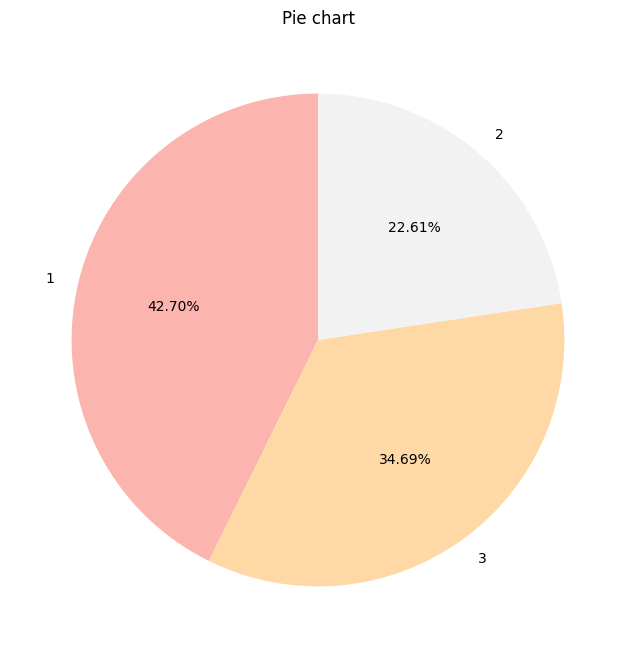

In [ ]:
# 对于target value的不同类别进行统计
B_colors = [cmap(i) for i in np.linspace(0, 1, len(y_B.value_counts()))]
plt.figure(figsize=(8, 8))
plt.pie(y_B.value_counts(), autopct='%.2f%%', startangle=90, labels=[i for i in y_B.value_counts().index], colors=B_colors)
plt.title('Pie chart')


In [ ]:


B_ovo, B_ovr = simple_nn_train(MLPClassifier(solver='adam', warm_start=True, early_stopping=True, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(256, 256)), X=X_B.iloc[:, :], y=y_B.iloc[:, 0], iter=150, only=['ovr'])

Iteration 15/ 150: Using Stragety ovr f1_score=0.564; roc_auc=0.759
Iteration 30/ 150: Using Stragety ovr f1_score=0.585; roc_auc=0.780
Iteration 45/ 150: Using Stragety ovr f1_score=0.612; roc_auc=0.802
Iteration 60/ 150: Using Stragety ovr f1_score=0.620; roc_auc=0.821
Iteration 75/ 150: Using Stragety ovr f1_score=0.635; roc_auc=0.835
Iteration 90/ 150: Using Stragety ovr f1_score=0.670; roc_auc=0.852
Iteration 105/ 150: Using Stragety ovr f1_score=0.663; roc_auc=0.855
Iteration 120/ 150: Using Stragety ovr f1_score=0.695; roc_auc=0.880
Iteration 135/ 150: Using Stragety ovr f1_score=0.718; roc_auc=0.892
Iteration 150/ 150: Using Stragety ovr f1_score=0.718; roc_auc=0.895
Final Summary: Iterations 150, Stragety ovr, f1_score=0.718, roc_auc=0.895
